In [108]:
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind, chi2_contingency
import numpy as np
from tqdm import tqdm


# TO DO LIST


## Step 1: Binarization of feature vectors

### Independant analysis

#### - Compute T-Test for continuous variables 
 - Sick group vs Not sick group
 - Compute p-value for statistical significancy of in/dependance
 - Keep only variables with p-val < 0.005
 
#### - Compute Chi-2 tests for categorial/nominal variables -> Sick vs Not Sick
 - Sick group vs Not sick group
 - Compute p-value for statistical significancy of in/dependance
 - Keep only variables with p-val < 0.005
 
###  Relationship/correlation analysis
 - Compute correlation/causality tests between features ? -> get rid of redundant variables 
 
### Aggregation & Binning

#### - Nominal variables (2+ modalities)
 - Aggregate modalities if modalities consist in a sequence of unique group representation
 
#### - Continuous variables
 - Compute bins based on global distribution/quantiles ?
 - Compute bins based on population (Sick vs Not Sick) ?
 - Compute bins based on majority population (Sick vs Not Sick) ?
 - TBD

## Step 2: Implement Rules Generation algorithm
 - TBD

In [109]:


def preprocess_columns(df):
    processed_features = {}
    columns = df.columns.tolist()
    for feature in columns:
        if df[feature].dtype in [int, float]:
            processed_features[feature] = df[feature].tolist()
        elif df[feature].dtype == object:
            processed_features[feature] = [label_dict[sample] for sample in df[feature]]
    return pd.DataFrame(processed_features)

def test_column_significance(feature, target):
    if feature_clf[feature.name] == 'num':
        feature_true = feature[target == 1]
        feature_false = feature[target == 0]
        tval, pval = ttest_ind(feature_true, feature_false)
        bt_diff_means = bootstrap_diff_means(feature, target)
        diff_means, boot_means, boot_ci = compute_confidence_interval(feature, bt_diff_means)
        stat = {'diff_means': diff_means, 'boot_means': boot_means, 'boot_ci': boot_ci, 'tval': tval, 'pval': pval, 'bt_diff_means': bt_diff_means}
    elif feature_clf[feature.name] == 'cat':
        contingency_table = pd.concat([feature, target], axis=1).pivot_table(index=feature.name, columns=target.name, aggfunc=len).fillna(0).copy().astype(int)
        g, pval, dof, expected = chi2_contingency(contingency_table)
        stat = {'g': g, 'pval': pval, 'dof': dof, 'expected': expected, 'cont': contingency_table}
    else:
        print(f'COLUMN NOT CLASSIFIED IN feature_clf: {feature.name}')
    return stat


def bootstrap_diff_means(feature, target, sample_size=1000, bt_size=1000):
    bt_diff_means = []
    for bootstrap_iter in range(sample_size):
        boot_index = np.random.randint(len(target), size = bt_size)
        boot_feature, boot_target = feature[boot_index], target[boot_index]
        true_boot_feature = boot_feature[boot_target == 1]
        false_boot_feature = boot_feature[boot_target == 0]
        bt_diff_means.append(true_boot_feature.mean() - false_boot_feature.mean())
    return bt_diff_means

def compute_confidence_interval(feature, bt_diff_means):
    diff_means = feature.mean()
    boot_means = np.mean(bt_diff_means)
    boot_ci = np.quantile(bt_diff_means, q=[0.025, 0.975])
    return diff_means, boot_means, boot_ci





In [110]:
seed = 18
np.random.seed(seed)

dataset_path = "data/kidney.csv"

df = pd.read_csv(dataset_path)


columns = df.columns.tolist()
features, target = columns[:-1], columns[-1]

feature_clf = {'age': 'num', 'bp': 'num', 'sg':'cat', 'al': 'cat', 'su': 'cat', 'rbc': 'cat', 'pc': 'cat', 'pcc': 'cat', 'ba': 'cat', 'bgr': 'num', 'bu': 'num', 'sc': 'num', 'sod': 'num', 'pot': 'num', 'hemo': 'num', 'pcv': 'num', 'wbcc': 'num', 'rbcc': 'num', 'htn': 'cat', 'dm': 'cat', 'cad': 'cat', 'appet': 'cat', 'pe': 'cat', 'ane': 'cat', 'class': 'cat'}

label_dict = {'normal': 0, 'abnormal': 1, 'notpresent': 0, 'present': 1, 'yes': 1, 'no': 0, 'ckd': 1, 'notckd': 0, 'good': 0, 'poor':1}

df_processed = preprocess_columns(df)
df_train, df_test = train_test_split(df_processed, test_size=0.2, random_state=seed)


In [111]:


res_stats = {}
for feature in tqdm(features):
    res_stats[feature] = test_column_significance(df_processed[feature], df_processed[target])

pval_threshold = 0.01
significant_features = [feature for feature in features if res_stats[feature]['pval'] < pval_threshold]

pval = {ft: res_stats[ft]['pval'] for ft in features}

100%|██████████| 23/23 [00:38<00:00,  1.66s/it]


In [ ]:
for feature in features:
    if feature_clf[feature] == 'cat':
        print(res_stats[feature]['cont'])

In [112]:
def get_aggregated_modalities(contingency_table):
    modalities = contingency_table.index.tolist()
    discr = False
    aggr = False
    aggr_mod = []
    aggr_mod_index = []
    for modality_index, modality in enumerate(modalities):
        if aggr is False:
            tmp_mod = []
            tmp_mod_index = []
        false, true = contingency_table.iloc[modality_index].to_numpy()
        if aggr is True and (false != 0 and true != 0):
            aggr_mod.append(tmp_mod)
            aggr_mod_index.append(tmp_mod_index)
            tmp_mod = []
            tmp_mod_index = []
            aggr = False
        if false == 0 or true == 0:
            aggr = True
        tmp_mod.append(modality)
        tmp_mod_index.append(modality_index)
        if not aggr:
            aggr_mod.append(tmp_mod)
            aggr_mod_index.append(tmp_mod_index)
    if aggr_mod[-1] != tmp_mod:
        aggr_mod.append(tmp_mod)
        aggr_mod_index.append(tmp_mod_index)
    return aggr_mod, aggr_mod_index


def compute_aggr_mod_bins(res_stats):
    
    new_mod_bins = {}
    for feature in features:
        if feature_clf[feature] == 'cat':
            if res_stats[feature]['dof'] > 2:
                aggregated_mod, aggregated_mod_index = get_aggregated_modalities(res_stats[feature]['cont'])
                if len(aggregated_mod) < res_stats[feature]['dof']:
                    # new_mod_bins[feature] = [np.min(mod) for mod in aggregated_mod]
                    new_mod_bins[feature] = aggregated_mod
    return new_mod_bins



def reduce_mod_features(df, new_mod_bins):
    new_modalities_dict = {}
    for feature, mod_bins in new_mod_bins.items():
        new_modalities_dict[feature] = {modality: bin_index for bin_index, mod_bin in enumerate(mod_bins) for modality in mod_bin}
        df[feature] = df[feature].apply(lambda x: new_modalities_dict[feature][x])
    return df, new_modalities_dict
    
        

In [113]:
new_mod_bins = compute_aggr_mod_bins(res_stats)
new_mod_bins.items()

dict_items([('sg', [[1.005, 1.01, 1.015], [1.02], [1.025]]), ('al', [[0], [1, 2, 3, 4]]), ('su', [[0], [1, 2, 3, 4, 5]])])

In [114]:
df_reprocessed, new_modalities_dict = reduce_mod_features(df_processed.copy(deep=True), new_mod_bins)
df_reprocessed

,age,bp,sg,al,su,pc,pcc,ba,bgr,bu,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48,70,0,1,0,1,1,0,117,56,...,32,6700,3.9,1,0,0,1,1,1,1
1,53,90,1,1,0,1,1,0,70,107,...,29,12100,3.7,1,1,0,1,0,1,1
2,63,70,0,1,0,1,1,0,380,60,...,32,4500,3.8,1,1,0,1,1,0,1
3,68,70,0,1,1,0,1,0,208,72,...,28,12200,3.4,1,1,1,1,1,0,1
4,68,80,0,1,1,1,1,1,157,90,...,16,11000,2.6,1,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,55,80,1,0,0,0,0,0,140,49,...,47,6700,4.9,0,0,0,0,0,0,0
185,42,70,2,0,0,0,0,0,75,31,...,54,7800,6.2,0,0,0,0,0,0,0
186,12,80,1,0,0,0,0,0,100,26,...,49,6600,5.4,0,0,0,0,0,0,0
187,17,60,2,0,0,0,0,0,114,50,...,51,7200,5.9,0,0,0,0,0,0,0


In [116]:
df_true = df_reprocessed[df_reprocessed['class'] == 1]
df_false = df_reprocessed[df_reprocessed['class'] == 0]

In [132]:
ft = 'bgr'

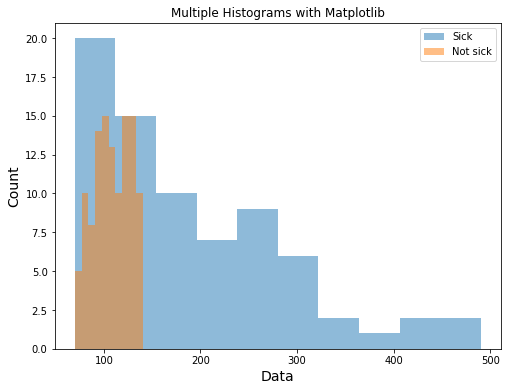

In [133]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.hist(df_true[ft], bins=10, alpha=0.5, label="Sick")
plt.hist(df_false[ft], bins=10, alpha=0.5, label="Not sick")
#plt.hist(df_reprocessed[ft], bins=10, alpha=0.5, label="Total")

plt.xlabel("Data", size=14)
plt.ylabel("Count", size=14)
plt.title("Multiple Histograms with Matplotlib")
plt.legend(loc='upper right')
#plt.savefig("overlapping_histograms_with_matplotlib_Python.png")

0      4
1      2
2      3
3      3
4      3
      ..
184    0
185    0
186    0
187    0
188    0
Name: al, Length: 189, dtype: int64

In [58]:
from collections import Counter
Counter(sorted(df_processed[ft]))

Counter({0: 131, 1: 9, 2: 12, 3: 22, 4: 15})

In [59]:
pd.cut(df_processed[ft], bins=mod_bins, labels=range(len(mod_bins)-1), include_lowest=False, right=False)

0      1
1      1
2      1
3      1
4      1
      ..
184    0
185    0
186    0
187    0
188    0
Name: al, Length: 189, dtype: category
Categories (2, int64): [0 < 1]

In [60]:
from collections import Counter
Counter(sorted(pd.cut(df_processed[ft], bins=mod_bins, labels=range(len(mod_bins)-1), include_lowest=False, right=False)))

Counter({0: 131, 1: 58})

In [75]:
df_processed[feature]

0      0
1      0
2      0
3      1
4      2
      ..
184    0
185    0
186    0
187    0
188    0
Name: su, Length: 189, dtype: int64

In [72]:
pd.cut(df_processed[feature], bins=mod_bins, labels=range(len(mod_bins)-1), include_lowest=False, right=False)

0        0
1        0
2        0
3      NaN
4      NaN
      ... 
184      0
185      0
186      0
187      0
188      0
Name: su, Length: 189, dtype: category
Categories (1, int64): [0]

In [ ]:
df_reprocessed[['sg', 'class']].pivot_table(index='sg', columns='class', aggfunc=len).fillna(0)

In [ ]:
ft = 'sg'
cont = res_stats[ft]['cont']

In [ ]:
cont[0].drop(cont[0][cont[0] == 0].index)

In [ ]:
modalities = cont.index.tolist()
cont.index.tolist()

In [ ]:
num_features = [ft for ft in features if feature_clf[ft] == 'num']
cat_features = [ft for ft in features if feature_clf[ft] == 'cat']

In [ ]:
multi_mod_ft = [ft for ft in cat_features if res_stats[ft]['dof'] > 2]

In [ ]:
df_processed['sg']

In [ ]:
df_processed